# Capstone Project - The Battle of the Neiborhoods - Scarborough

### Installing and importing the required libraries

In [1]:
!pip install geocoder
!pip install folium

     |████████████████████████████████| 98 kB 2.1 MB/s eta 0:00:01


In [2]:
# Importing the required libraries

import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Getting the Data and Cleaning it

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

In [4]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [5]:
# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [6]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue)
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned


In [7]:
df.describe()

,Postalcode,Borough,Neighborhood
count,20,20,20
unique,20,20,20
top,\nM1RScarborough(Wexford / Maryvale)\n\n,\nM2BNot assigned\n\n,M9AEtobicoke(Islington Avenue)
freq,1,1,1


In [8]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [9]:
df.head()

,Postalcode,Borough,Neighborhood
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue)
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned


In [13]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))

grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name = 'Neighborhood')

In [14]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,20,20,20
unique,20,20,20
top,\nM1RScarborough(Wexford / Maryvale)\n\n,\nM2BNot assigned\n\n,M9AEtobicoke(Islington Avenue)
freq,1,1,1


In [15]:
print(df_2.shape)

(20, 3)


In [16]:
df_2.head()

,Postalcode,Borough,Neighborhood
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue)
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned


In [17]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.709020000000066, -79.36348999999996]

In [18]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [19]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [20]:
df_2[df_2.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude


In [21]:
df_2.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue),43.64869,-79.38544
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...,43.81023,-79.22038
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...,43.78948,-79.17614
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned,43.76343,-79.17820
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned,43.76748,-79.22829


In [24]:
latitude_x = 43.77307
longitude_y = -79.257774

## Plotting of the map

In [25]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In order to see the map you have to make this Notebook Trusted : File --> Trust Notebook

In [32]:
latitude_n1 = 43.773077
longitude_n1 = -79.257774

In [33]:
CLIENT_ID = 'DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY' # my Foursquare ID
CLIENT_SECRET = '1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY
CLIENT_SECRET: 1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B


In [34]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [35]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [46]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Venues in the vicinity

In [54]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

nearby_venues.head(20)

,name,categories,lat,lng
0,Hot Topic,Clothing Store,43.775450,-79.257929
1,Tommy Hilfiger,Clothing Store,43.776015,-79.257369
2,New York Fries - Scarborough TC,Restaurant,43.775135,-79.256858
3,lululemon athletica,Clothing Store,43.775517,-79.258423
4,Subway,Sandwich Place,43.775102,-79.257115
5,Subway,Sandwich Place,43.771477,-79.252805
6,Petro-Canada,Gas Station,43.769724,-79.261677
7,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
8,Disney Store,Toy / Game Store,43.775537,-79.256833
9,Scaddabush Italian Kitchen & Bar,Italian Restaurant,43.777460,-79.254358


In [55]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store      7
Restaurant          5
Coffee Shop         4
Intersection        2
Sandwich Place      2
Gas Station         2
Department Store    2
Pharmacy            2
Tea Room            1
Discount Store      1
Name: categories, dtype: int64

In [56]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [57]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

M9AEtobicoke(Islington Avenue)
M9BEtobicoke(West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)
M9CEtobicoke(Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood)
M9ENot assigned
M9GNot assigned
M9HNot assigned
M9JNot assigned
M9KNot assigned
M9LNorth York(Humber Summit)
M9MNorth York(Humberlea / Emery)
M9NYork(Weston)
M9PEtobicoke(Westmount)
M9REtobicoke(Kingsview Village / St. Phillips / Martin Grove Gardens / Richview Gardens)
M9SNot assigned
M9TNot assigned
M9VEtobicoke(South Steeles / Silverstone / Humbergate / Jamestown / Mount Olive / Beaumond Heights / Thistletown / Albion Gardens)
M9WEtobicokeNorthwest(Clairville / Humberwood / Woodbine Downs / West Humber / Kipling Heights / Rexdale / Elms / Tandridge / Old Rexdale)
M9XNot assigned
M9YNot assigned
M9ZNot assigned


In [59]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head(3)

There are 102 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
M9AEtobicoke(Islington Avenue),100,100,100,100,100,100
M9BEtobicoke(West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale),15,15,15,15,15,15
M9CEtobicoke(Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood),3,3,3,3,3,3


In [60]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Yoga Studio,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,Beer Bar,Beer Store,Big Box Store,Bistro,Bookstore,Brazilian Restaurant,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Stop,Butcher,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Coffee Shop,College Stadium,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Discount Store,Fast Food Restaurant,Fish Market,Food Court,Fried Chicken Joint,Furniture / Home Store,Gastropub,General Entertainment,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Home Service,Hong Kong Restaurant,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Museum,Neighborhood,New American Restaurant,Opera House,Park,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pub,Ramen Restaurant,Rental Car Location,Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skating Rink,Soup Place,Speakeasy,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Thai Restaurant,Theater,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- M9AEtobicoke(Islington Avenue) ----
         venue  freq
0  Coffee Shop  0.09
1        Hotel  0.08
2         Café  0.05
3   Restaurant  0.04
4     Beer Bar  0.03


---- M9BEtobicoke(West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale) ----
                  venue  freq
0  Fast Food Restaurant  0.20
1           Pizza Place  0.13
2              Pharmacy  0.13
3                  Park  0.13
4     Convenience Store  0.07


---- M9CEtobicoke(Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood) ----
                       venue  freq
0               Home Service  0.33
1          Convenience Store  0.33
2                Yoga Studio  0.00
3  Middle Eastern Restaurant  0.00
4                 Playground  0.00


---- M9ENot assigned ----
                  venue  freq
0                  Park   0.4
1  Gym / Fitness Center   0.2
2            Restaurant   0.2
3     Convenience Store   0.2
4           Yoga Studio   0.0


---- M9GNot assigned ----
               

In [62]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Most common venues nearby

In [64]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(3)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M9AEtobicoke(Islington Avenue),Coffee Shop,Hotel,Café,Restaurant,Beer Bar,Furniture / Home Store,Bookstore,Italian Restaurant,Gym,Japanese Restaurant
1,M9BEtobicoke(West Deane Park / Princess Garden...,Fast Food Restaurant,Pharmacy,Pizza Place,Park,Supermarket,Grocery Store,Bubble Tea Shop,Sandwich Place,Convenience Store,Skating Rink
2,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...,Convenience Store,Home Service,Wings Joint,Fast Food Restaurant,Coffee Shop,College Stadium,Comedy Club,Concert Hall,Cosmetics Shop,Deli / Bodega


## Clustering by k-means

In [71]:
neighborhoods_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head(3) # Check the last columns to look at the rankings

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue),43.64869,-79.38544,0,0,Coffee Shop,Hotel,Café,Restaurant,Beer Bar,Furniture / Home Store,Bookstore,Italian Restaurant,Gym,Japanese Restaurant
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...,43.81023,-79.22038,0,0,Fast Food Restaurant,Pharmacy,Pizza Place,Park,Supermarket,Grocery Store,Bubble Tea Shop,Sandwich Place,Convenience Store,Skating Rink
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...,43.78948,-79.17614,0,0,Convenience Store,Home Service,Wings Joint,Fast Food Restaurant,Coffee Shop,College Stadium,Comedy Club,Concert Hall,Cosmetics Shop,Deli / Bodega


## Map

In [72]:
kclusters = 10

In [73]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Label']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In order to see the map you have to make this Notebook Trusted : File --> Trust Notebook

In [74]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Label'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Label'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Label'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [79]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"].head(20),
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0
                                                              
                                                              
                                                              ]})

In [81]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

<AxesSubplot:xlabel='Neighborhood'>

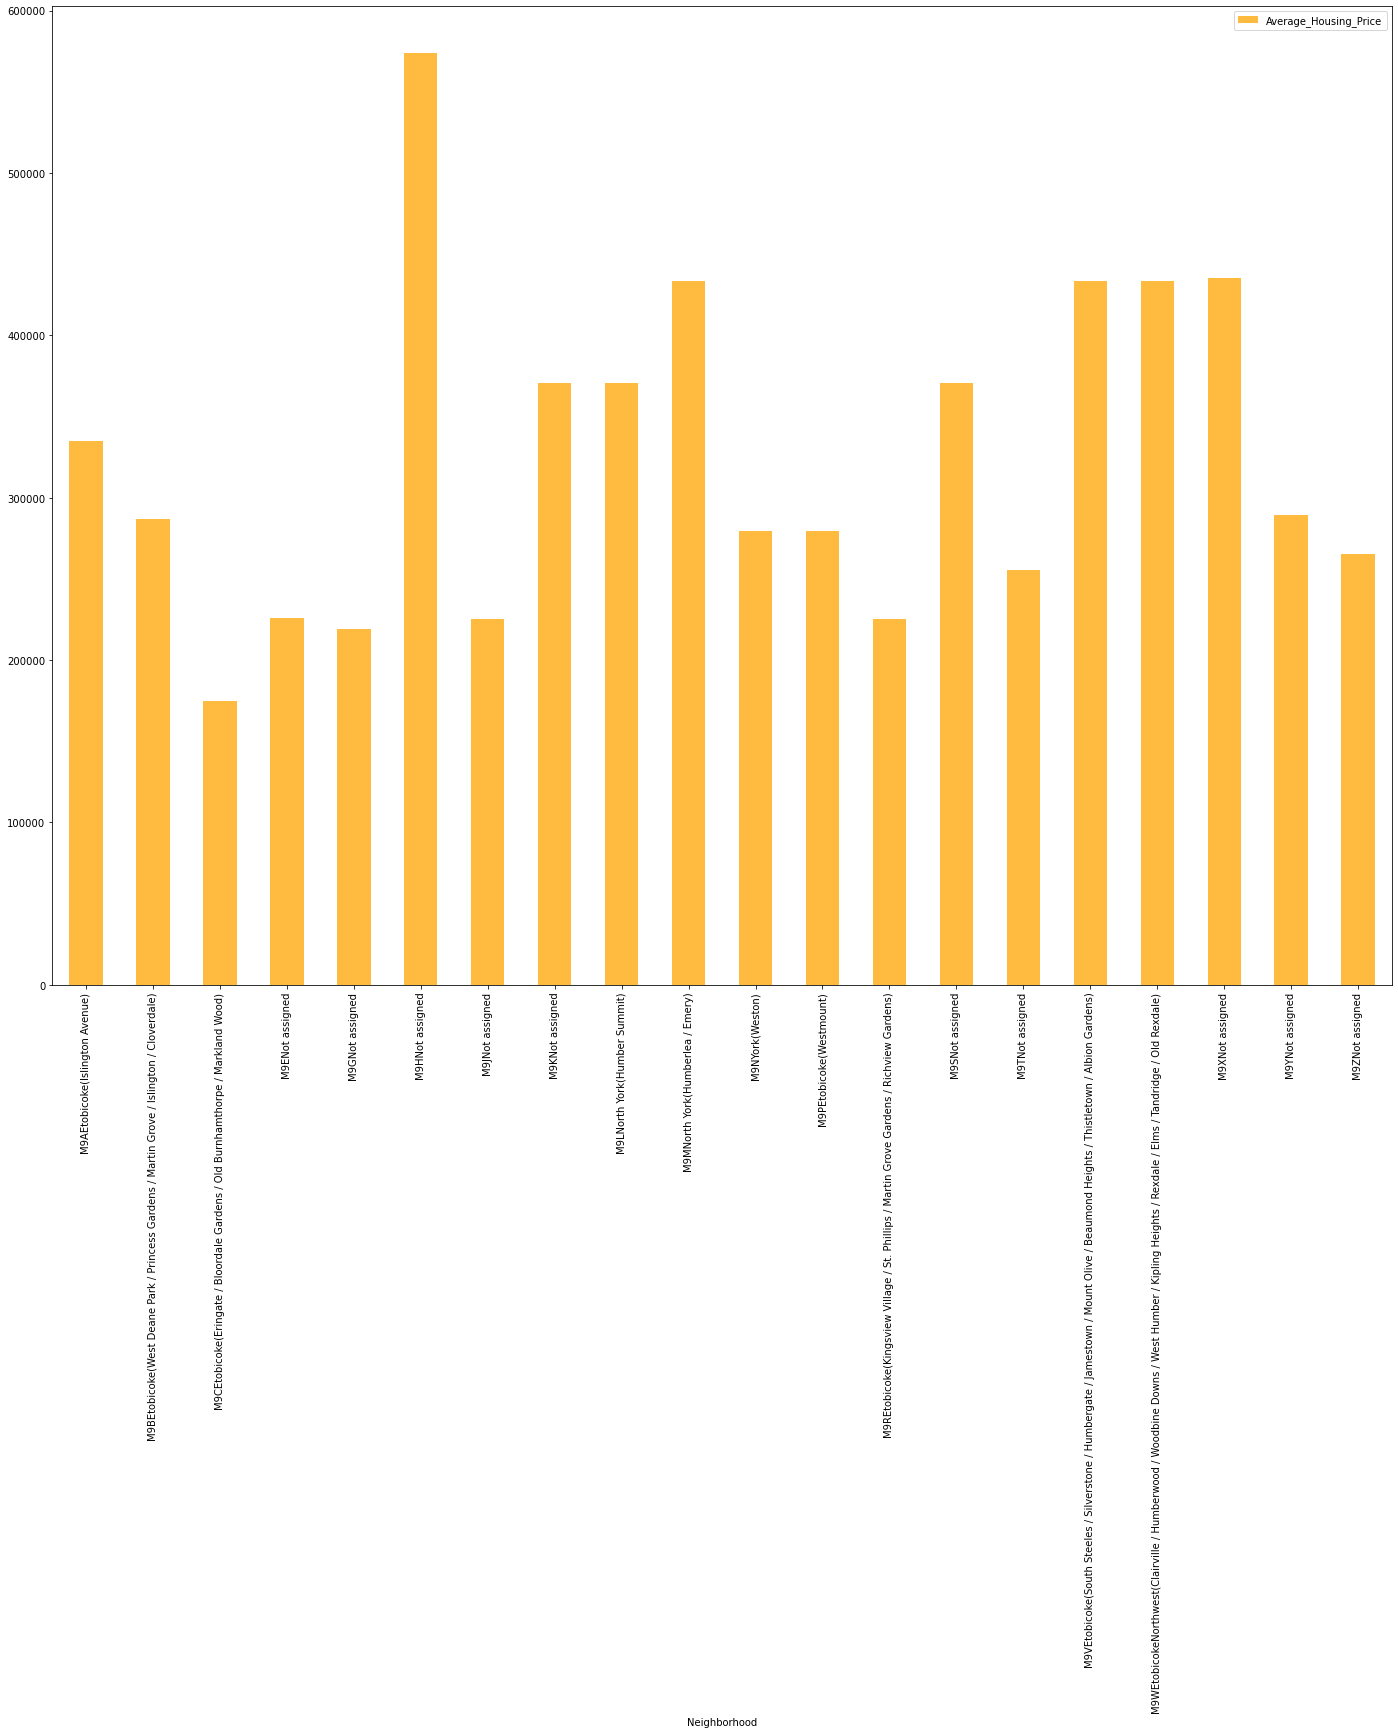

In [85]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18), color = 'orange', alpha=0.75)

## School Ratings

In [86]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [87]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"].head(20),
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8
                                                           ]})

In [88]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

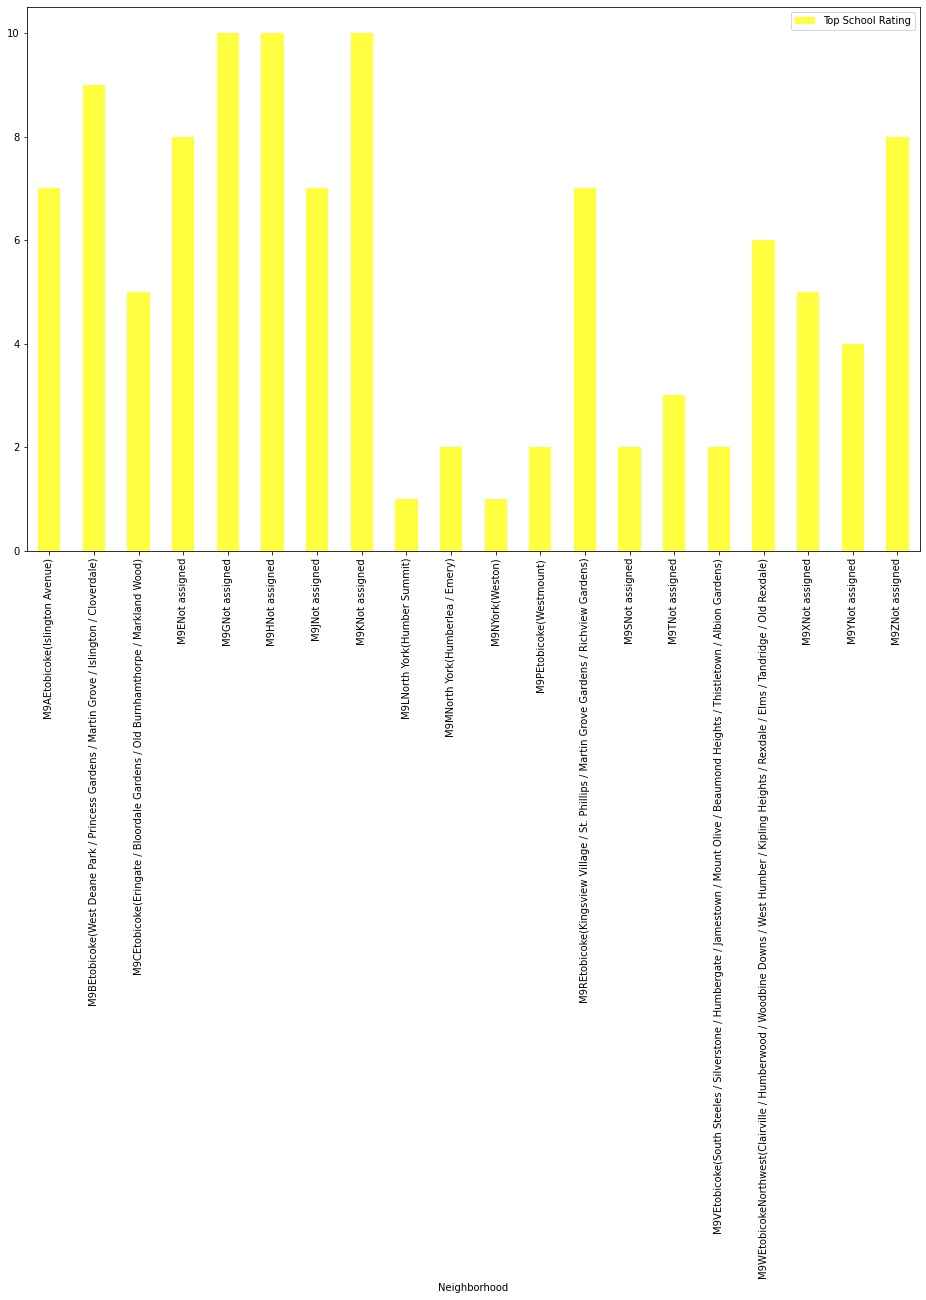

In [89]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='yellow',alpha=0.75);